# Spliting Data

Before conducting data preprocessing, I will separate the test set to assess the model's effectiveness. It is crucial for the model to generalize well, avoiding issues such as underfitting, where the model performs poorly on both training and validation data, or overfitting, where the model overly adapts to the training data and struggles to generalize to new data. The separation before standardization is done to ensure that the test data remains unseen during training and validation, simulating a real-world scenario.

In [138]:

# Bibliotecas padrão
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow 
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.io as pio
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly as ply

# Visualização de dados
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import missingno

# Testes estatísticos
from scipy.stats import chi2_contingency, mannwhitneyu
import scipy.stats as stats

# Modelos de machine learning e utilitários
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import (roc_curve, auc, confusion_matrix, log_loss, roc_auc_score,
                             precision_score, recall_score, f1_score, make_scorer)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
from sklearn.preprocessing import StandardScaler

# Classificadores e métodos de ensemble
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

In [139]:
file_path = "data/fraud_data.xlsx"

df = df = pd.read_excel(file_path)
df.head()

,score_1,score_2,score_3,score_4,score_5,score_6,pais,score_7,produto,categoria_produto,score_8,score_9,score_10,entrega_doc_1,entrega_doc_2,entrega_doc_3,data_compra,valor_compra,score_fraude_modelo,fraude
0,4,0.7685,94436.24,20.0,0.444828,1.0,BR,5,Máquininha Corta Barba Cabelo Peito Perna Pelo...,cat_8d714cd,0.883598,240.0,102.0,1,NaN,N,2020-03-27 11:51:16,5.64,66,0
1,4,0.7550,9258.50,1.0,0.000000,33.0,BR,0,Avental Descartavel Manga Longa - 50 Un. Tnt ...,cat_64b574b,0.376019,4008.0,0.0,1,Y,N,2020-04-15 19:58:08,124.71,72,0
2,4,0.7455,242549.09,3.0,0.000000,19.0,AR,23,Bicicleta Mountain Fire Bird Rodado 29 Alumini...,cat_e9110c5,0.516368,1779.0,77.0,1,NaN,N,2020-03-25 18:13:38,339.32,95,0
3,4,0.7631,18923.90,50.0,0.482385,18.0,BR,23,Caneta Delineador Carimbo Olho Gatinho Longo 2...,cat_d06e653,0.154036,1704.0,1147.0,1,NaN,Y,2020-04-16 16:03:10,3.54,2,0
4,2,0.7315,5728.68,15.0,0.000000,1.0,BR,2,Resident Evil Operation Raccoon City Ps3,cat_6c4cfdc,0.855798,1025.0,150.0,1,NaN,N,2020-04-02 10:24:45,3.53,76,0


In [140]:
def split_df(df):
    df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
    return df_train, df_test

df_train, df_test = split_df(df)

X_train = df_train.drop('fraude', axis=1)
y_train = df_train['fraude']

X_test = df_test.drop('fraude', axis=1)
y_test = df_test['fraude']

# Baseline Model

Firstly, we will assess the distribution of the current model. It is evident that the model is far from ideal, as there is a significant overlap between fraudulent and legitimate transactions in the classification

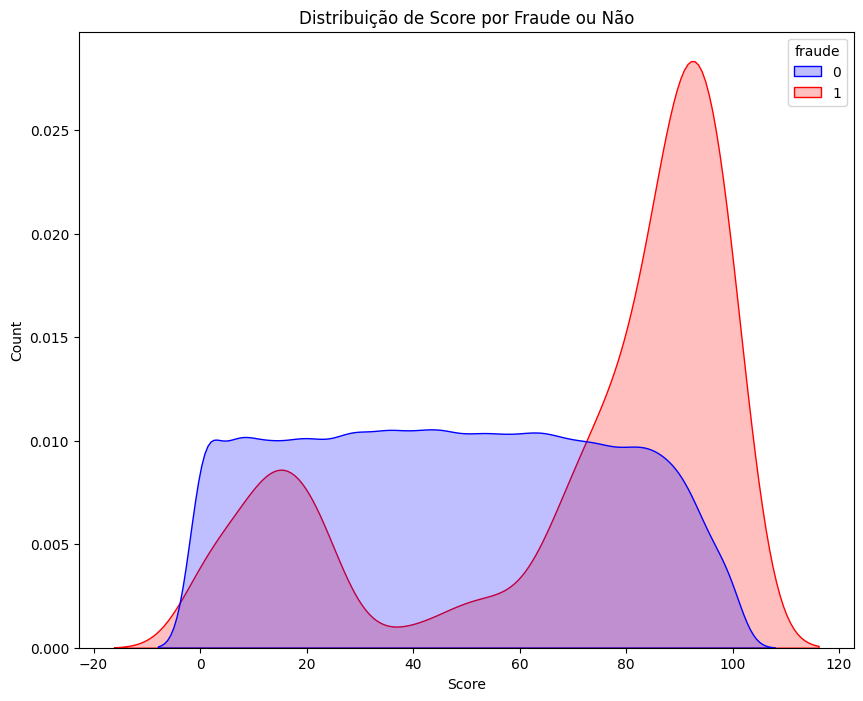

In [141]:
plt.figure(figsize=(10, 8))
sns.kdeplot(data=df, x='score_fraude_modelo', hue='fraude', fill=True, common_norm=False, palette={0: 'blue', 1: 'red'})

plt.title("Distribuição de Score por Fraude ou Não")
plt.xlabel("Score")
plt.ylabel("Count")
plt.show();

We will now assess other metrics such as AUC, confusion matrix, and the like.

* AUC (Area Under the Curve): AUC is a metric that evaluates the performance of a classification model, particularly for binary classification. It represents the area under the Receiver Operating Characteristic (ROC) curve, providing a measure of how well the model distinguishes between classes. A higher AUC indicates better model performance.

* Confusion Matrix: A confusion matrix is a table that summarizes the performance of a classification algorithm. It shows the count of true positive, true negative, false positive, and false negative predictions. The diagonal elements represent correct predictions, while off-diagonal elements indicate misclassifications. The matrix is a valuable tool for understanding the model's accuracy, precision, recall, and other performance metrics.

In [142]:
fpr, tpr, thresholds = roc_curve(df['fraude'], df['score_fraude_modelo'])
auc = auc(fpr, tpr)
print("ROC AUC: ", auc)

ROC AUC:  0.726275487251462


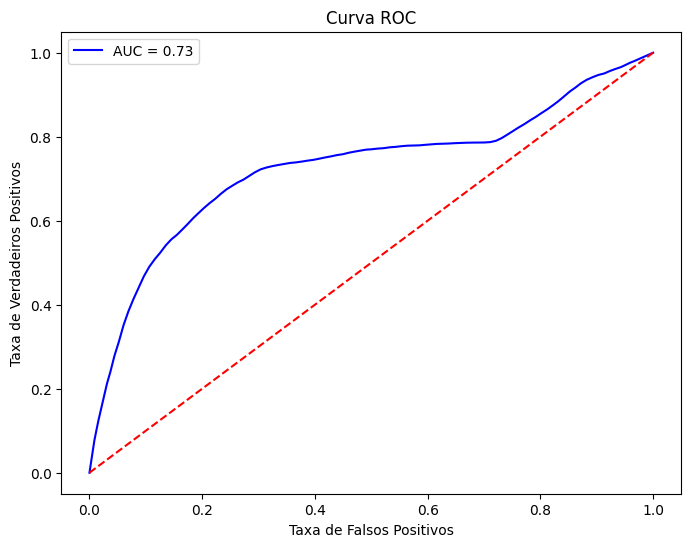

In [143]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}', color='b')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

Finally, we will assess the threshold that maximizes profit and plot the other metrics. It will be assumed that the purchase value is in a single unit of measure

In [144]:
def calculate_profit_metrics(decision_df, blocked_col, target_col, amount_col):
    """
    Calculates fraud losses, revenues, and profit based on the given decision dataframe.

    Parameters:
    - decision_df (pd.DataFrame): Dataframe containing decision data
    - blocked_col (str): Name of the column indicating if a transaction was blocked
    - target_col (str): Name of the column indicating if a transaction was a fraud
    - amount_col (str): Name of the column indicating the transaction amount

    Returns:
    pd.Series: Series containing summed values of fraud losses, revenues, and profit
    """

    # Fraud losses: Amount lost due to undetected fraud (not blocked but is fraud)
    decision_df["fraud_losses"] = (
        (~decision_df[blocked_col]) & (decision_df[target_col])
    ) * decision_df[amount_col]

    # Revenues: Amount earned from legitimate transactions (not blocked and not fraud)
    decision_df["revenues"] = (
        (~decision_df[blocked_col]) & (~decision_df[target_col])
    ) * decision_df[amount_col] * 0.1  # Assuming 10% revenue from legitimate transactions

    # Profit: Revenues minus Fraud losses
    decision_df["profit"] = decision_df["revenues"] - decision_df["fraud_losses"]

    return decision_df[["fraud_losses", "revenues", "profit"]].sum()


target_col = "fraude"
prediction_col = "score_fraude_modelo"
amount_col = "valor_compra" 
blocked_col = "blocked"

possible_thresholds = np.arange(1, 100, 1)
all_decisions = []

for threshold in possible_thresholds: 
    all_decisions.append(calculate_profit_metrics(df_test.assign(blocked=lambda df_test: df_test[prediction_col] >= threshold), blocked_col, 
                                              target_col, amount_col)
                         )
    

threshold_evaluation = pd.concat(all_decisions, axis=1, keys=[s for s in possible_thresholds]).T.rename_axis("threshold").reset_index()
threshold_evaluation

,threshold,fraud_losses,revenues,profit
0,1,1181.23,3242.109,2060.879
1,2,1890.99,3917.883,2026.893
2,3,1969.12,4829.258,2860.138
3,4,2288.36,5726.876,3438.516
4,5,2692.96,6743.685,4050.725
...,...,...,...,...
94,95,84125.99,111680.516,27554.526
95,96,87603.24,112932.551,25329.311
96,97,90925.22,113735.367,22810.147
97,98,94238.31,114322.705,20084.395


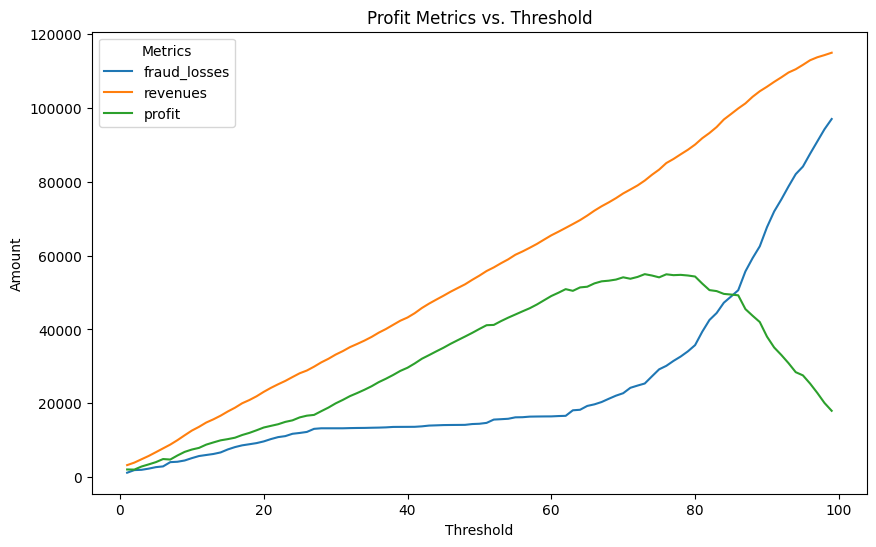

In [145]:
# Convertendo para o formato "amplo"
df_melted = pd.melt(threshold_evaluation, id_vars='threshold', 
                    value_vars=['fraud_losses', 'revenues', 'profit'], 
                    var_name='Metric', value_name='Amount')

# Plotando com seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_melted, x='threshold', y='Amount', hue='Metric')
plt.title('Profit Metrics vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Amount')
plt.legend(title='Metrics')
plt.show()


In [146]:
best_threshold = threshold_evaluation.loc[threshold_evaluation["profit"].idxmax(), "threshold"]
best_decision_anterior = calculate_profit_metrics(df_test.assign(blocked=lambda df_test: df_test[prediction_col] >= best_threshold), blocked_col,
                                                target_col, amount_col)

## print the results of the best threshold in a dataframe
best_decision = best_decision_anterior.to_frame().T
best_decision["threshold"] = best_threshold
best_decision.T.rename_axis("metric").rename(columns={0: "$"}).reset_index()

,metric,$
0,fraud_losses,25353.320
1,revenues,80329.995
2,profit,54976.675
3,threshold,73.000


In [147]:
## print profit ratio
profit_ratio = best_decision["profit"] / best_decision["revenues"]


With the current model, there is a loss of 25 thousand due to frauds, a gain of 80 thousand, and ultimately a profit of 54 thousand. However, it is important to note that these data are samples and do not reflect the entire dataset

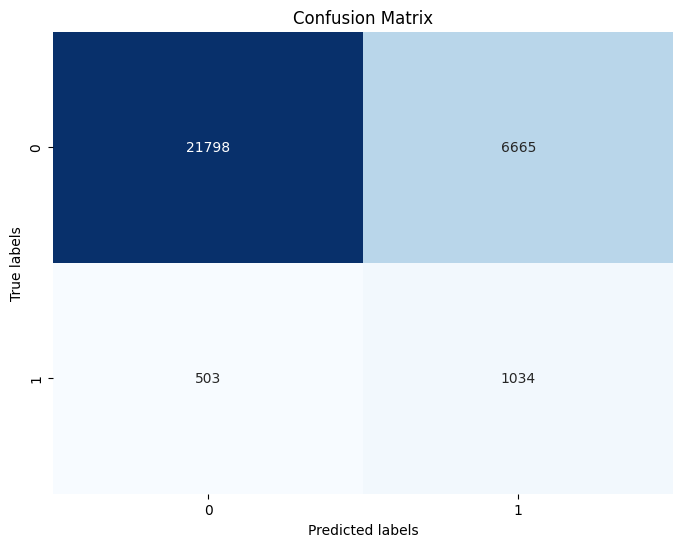

In [148]:
def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.show()


df_test['predicted'] = df_test['score_fraude_modelo'].apply(lambda x: 1 if x >= best_threshold else 0)
cm = confusion_matrix(df_test['fraude'], df_test['predicted'])
plot_confusion_matrix(cm)

In [149]:
## get the number of true positives, false positives, true negatives, and false negatives
tn, fp, fn, tp = cm.ravel()

## calculate fraud rate and aproval rate
fraud_rate = round(fn / (fn + tn), 2)
approval_rate = round((fn + tn) / (tp + fp + tn + fn), 2)

## print the results
print("Fraud rate: ", fraud_rate)
print("Approval rate: ", approval_rate)

Fraud rate:  0.02
Approval rate:  0.74


As seen above, our **fraud rate** is 2%, and the **approval rate** is 74%!

Now, let's explore additional metrics of the model, such as log loss, AUC, and others.

In [150]:
## calculate log loss, AUC, precision, recall, and F1 score
log_loss_score = log_loss(df_test['fraude'], df_test['predicted'])
auc_score = roc_auc_score(df_test['fraude'], df_test['predicted'])

precision = precision_score(df_test['fraude'], df_test['predicted'])
recall = recall_score(df_test['fraude'], df_test['predicted'])
f1 = f1_score(df_test['fraude'], df_test['predicted'])

## print the results
print("Log loss: ", log_loss_score)
print("AUC: ", auc_score)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 score: ", f1)

Log loss:  8.61203024977306
AUC:  0.7192877255456416
Precision:  0.13430315625405898
Recall:  0.6727391021470397
F1 score:  0.22390645300996104


# Preprocessing

## Notes
* The column `valor_compra` refers to the purchase amount and is in a single unit (e.g., Dollar).
* There is no additional fraud cost beyond what has been mentioned.
* None of the columns introduced into the model should cause data leakage - meaning all this data is calculated/received before the "Fraud" event occurs.

## For preprocessing, I chose to:
* Exclude the `score_fraude_modelo` column, which is the baseline model and should not be used.
* Exclude the `data_compra` column to avoid degrading the model over time.
* Exclude the `produto` column due to its high cardinality (more than 8 thousand categories).
* Retain the top 1000 categories in `categoria_produto` that account for 80% of fraud cases.
* Limit the `país` column to BR and AR (which together make up more than 90% of the entire distribution) and group others.
* Fill missing score values with the median, as they do not follow a normal distribution.
* Create a feature `is_null` indicating which values of entrega_doc_2 are null.
* Consider null values in `entrega_doc_2` as 0, meaning not delivered.
Apply target encoding to the variable `categoria_produto` due to its high cardinality.
Apply one-hot encoding to the remaining categorical variables.

In [151]:
class ColumnDropper(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(columns=['data_compra', 'produto', 'score_fraude_modelo', 'categoria_produto'], axis = 1)
    
class DataProcessor(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        
        # Cria a coluna 'is_missing' com 1 para valores ausentes e 0 para valores não ausentes
        X_copy['is_missing'] = X_copy['entrega_doc_2'].isnull().astype(int)
        
        # Preenche os valores nulos com 0
        X_copy['entrega_doc_2'] = X_copy['entrega_doc_2'].fillna('N')
        X_copy['entrega_doc_2'] = X_copy['entrega_doc_2'].apply(lambda x: 1 if x == 'Y' else 0)

        # Processamento de colunas específicas
        X_copy['pais'] = X_copy['pais'].apply(lambda x: x if x in ['BR', 'AR'] else 'Outros')
        X_copy['entrega_doc_3'] = X_copy['entrega_doc_3'].apply(lambda x: 1 if x == 'Y' else 0)
       
        return X_copy

class ScoreImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.imputers = {}
    
    def fit(self, X, y = None):
        cols = ['score_2', 'score_3', 'score_4', 'score_5', 'score_6', 'score_7', 'score_8', 'score_9', 'score_10']
        for col in cols:
            imputer = SimpleImputer(strategy = "median")
            imputer.fit(X[[col]])
            self.imputers[col] = imputer
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        for col, imputer in self.imputers.items():
            X_copy[col] = imputer.transform(X_copy[[col]])
        return X_copy
    
    
class OneHotFeatureEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.encoder = OneHotEncoder(sparse=False)  # Configurar sparse para False para retornar array denso
        self.cols = ['score_1', 'pais', 'entrega_doc_1', 'entrega_doc_2', 'entrega_doc_3', 'is_missing']
    
    def fit(self, X, y=None):
        self.encoder.fit(X[self.cols])
        return self
    
    def transform(self, X):
        onehot_data = self.encoder.transform(X[self.cols])
        
        # Convertendo o array onehot_data em um DataFrame
        onehot_df = pd.DataFrame(onehot_data, columns=self.encoder.get_feature_names_out(self.cols))
        
        # Para garantir que os índices estejam alinhados, vamos redefinir o índice do onehot_df para corresponder ao de X
        onehot_df.index = X.index
        
        X = X.drop(self.cols, axis=1)
        X = pd.concat([X, onehot_df], axis=1)
        
        return X
    
class KFoldTargetEncoder(BaseEstimator, TransformerMixin):

    def __init__(self):

        self.colnames = 'categoria_produto'
        self.targetName = 'fraude'
        self.n_fold = 5
        self.verbosity = True
        self.discardOriginal_col = False

    def fit(self, X, y=None):
        return self
    
    def transform(self,X):

        assert(type(self.targetName) == str)
        assert(type(self.colnames) == str)
        assert(self.colnames in X.columns)
        assert(self.targetName in X.columns)

        mean_of_target = X[self.targetName].mean()
        kf = KFold(n_splits = self.n_fold, shuffle = True, random_state=42)


        col_mean_name = self.colnames + '_' + 'Kfold_Target_Enc'
        X[col_mean_name] = np.nan

        for tr_ind, val_ind in kf.split(X):
            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]
            X.loc[X.index[val_ind], col_mean_name] = X_val[self.colnames].map(X_tr.groupby(self.colnames)[self.targetName].mean())

        X[col_mean_name].fillna(mean_of_target, inplace = True)

        if self.verbosity:
            encoded_feature = X[col_mean_name].values
            
        if self.discardOriginal_col:
            X = X.drop(self.targetName, axis=1)
            

        return X

def pipeline(model):
    
    # Criando o pipeline
    pipe = Pipeline([
        ("dropper", ColumnDropper()),
        ("processor", DataProcessor()),
        ("imputer", ScoreImputer()),
        ("onehot", OneHotFeatureEncoder()),
        ('classifier', model)
    ])
    
    return pipe

In [152]:
def create_df_product_category(df, fraud_df, fraud_threshold=80):
    """
    Create df_product_category DataFrame with information about each category.

    Parameters:
    - df: DataFrame containing the original data
    - fraud_df: DataFrame containing fraud data
    - fraud_threshold: Cumulative percentage threshold for fraud

    Returns:
    - df_product_category: DataFrame with information about each category
    """

    # Count the amount of items for each category
    numbers_of_items_for_category = df['categoria_produto'].value_counts().reset_index()
    numbers_of_items_for_category.rename(columns={'count': 'amount_of_items'}, inplace=True)

    # Count the percentage of fraud for each category
    percentage_of_fraud_for_category = (fraud_df['categoria_produto'].value_counts(normalize=True) * 100).reset_index()
    percentage_of_fraud_for_category.rename(columns={'proportion': 'percentage_of_fraud'}, inplace=True)

    # Count the amount of fraud for each category
    amount_of_fraud_for_category = fraud_df['categoria_produto'].value_counts().reset_index()
    amount_of_fraud_for_category.rename(columns={'count': 'amount_of_frauds'}, inplace=True)

    # Merge amount of items, percentage of fraud, and amount of fraud for each category
    df_product_category = pd.merge(numbers_of_items_for_category, percentage_of_fraud_for_category, on='categoria_produto')
    df_product_category = pd.merge(df_product_category, amount_of_fraud_for_category, on='categoria_produto', how='left')

    # Add the cumulative sum of percent of fraud
    df_product_category['cumsum_%_frauds'] = df_product_category['percentage_of_fraud'].cumsum()

    # Filter the cumulative sum <= fraud_threshold
    df_product_category_filtered = df_product_category[df_product_category['cumsum_%_frauds'] <= fraud_threshold]

    print(len(df_product_category_filtered), 'categories represent', fraud_threshold, '% of fraud')

    return df_product_category_filtered

df_copy = df.copy()

# Cria um DataFrame com informações sobre cada categoria
df_product_category = create_df_product_category(df_copy, df_copy[df_copy['fraude'] == 1])
# Mantém as categorias filtradas e marca as não selecionadas como "Outros"

selected_categories = df_product_category['categoria_produto']

# Atualiza o DataFrame original marcando as categorias não selecionadas como "Outros"
df_copy.loc[~df_copy["categoria_produto"].isin(selected_categories), "categoria_produto"] = "Outros"

# Divide o DataFrame em conjuntos de treinamento e teste
df_train, df_test = split_df(df_copy)
        
# Cria um encoder usando Target Encoder para o grupo de categorias devido à alta cardinalidade
target_encoder = KFoldTargetEncoder()
df_train = target_encoder.fit_transform(df_train)
df_test = target_encoder.transform(df_test)

# Separa características e rótulos para treinamento
X_train = df_train.drop('fraude', axis=1)
y_train = df_train['fraude']

# Separa características e rótulos para teste
X_test = df_test.drop('fraude', axis=1)
y_test = df_test['fraude']


837 categories represent 80 % of fraud


# Training the models

Our goal maximing ROC AUC score

Balanced RF: 0.8429 (±0.0042)
[LightGBM] [Info] Number of positive: 4754, number of negative: 91246
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2435
[LightGBM] [Info] Number of data points in the train set: 96000, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 4741, number of negative: 91259
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2435
[LightGBM] [Info] Number of data points in the train set: 96000, number of used featu

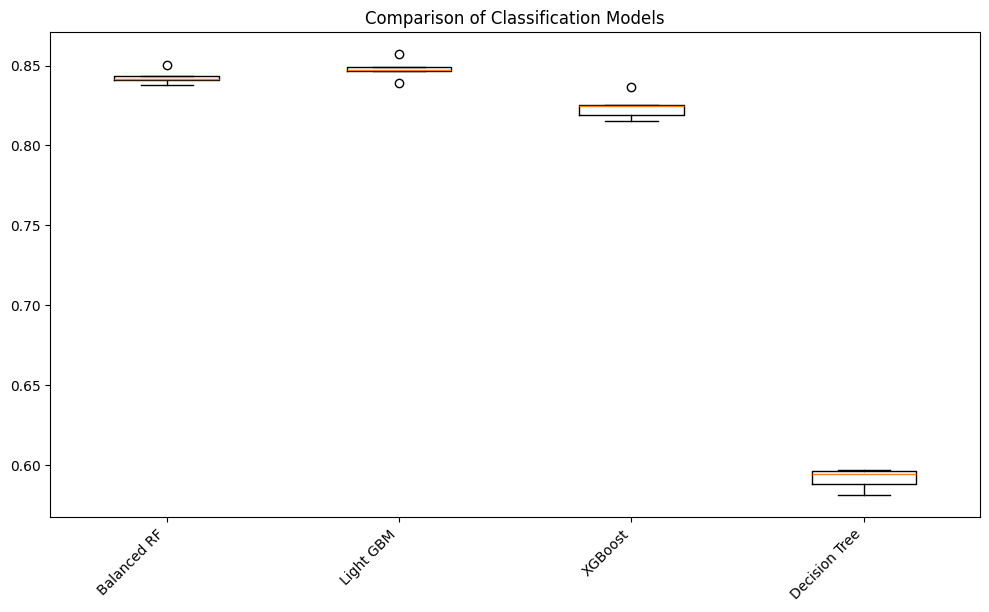

In [153]:
# Definindo os modelos
BRC = BalancedRandomForestClassifier(random_state=1234)
XGB = XGBClassifier(scale_pos_weight=19, random_state=1234)
LGB = LGBMClassifier(class_weight='balanced', random_state=1234)
DTC = DecisionTreeClassifier(class_weight='balanced', random_state=1234)

# Criando um dicionário de modelos para facilitar a iteração
models = {
    "Balanced RF": BRC,
    "Light GBM": LGB,
    "XGBoost": XGB,
    "Decision Tree": DTC
}

results = []

# Treinando os modelos e coletando os resultados
for name, model in models.items():
    pipe = pipeline(model)
    
    kfold = KFold(n_splits=5, random_state=42, shuffle=True)
    cv_results = cross_val_score(pipe, X_train, y_train, cv=kfold, scoring='roc_auc')
    results.append(cv_results)
    msg = f"{name}: {cv_results.mean():.4f} (±{cv_results.std():.4f})"
    print(msg)

# Plot comparison of models
fig, ax = plt.subplots(figsize=(10, 6))  # Increase the size for better clarity
ax.boxplot(results)
ax.set_xticklabels(models.keys())  # Set x-ticks to model names
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)  # Rotate and adjust fontsize of x-labels
plt.tight_layout()  # Adjust layout
plt.title('Comparison of Classification Models')
plt.show()

Among the tested models, the `Decision Tree` performed the worst. Both the Balanced `RF` and `Light GBM` achieved the best results, with `XGBoost` showing similar performance. I chose to proceed with `Light GBM` due to its consistency and fast processing.

# Hyperparameter Tuning

I will use Randomized Search CV to perform hyperparameter tuning. Randomized Search CV is an approach to hyperparameter optimization that differs from the traditional grid search method (GridSearchCV). Instead of searching through all possible combinations of hyperparameters (as GridSearchCV does), RandomizedSearchCV randomly selects a fixed number of hyperparameter combinations from a space of possibilities.

In [154]:
import mlflow
import mlflow.sklearn
from sklearn.model_selection import RandomizedSearchCV

# Set MLflow tracking URI and experiment
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment(experiment_name="Pipeline - Teste")

# Start MLflow run
with mlflow.start_run(run_name="Sem log - Light GBM"):

    np.random.seed(42)
    
    # Create LightGBM model and pipeline
    LGB = LGBMClassifier(class_weight='balanced', random_state=1234)
    pipe = pipeline(LGB)

    parameters = {
        'classifier__num_leaves': [31, 50, 100, 150],
        'classifier__max_depth': [10, 20, 30, 40, -1],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__n_estimators': [80, 100, 150, 200],
        'classifier__min_child_samples': [5, 10, 20, 50],
        'classifier__min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1],
        'classifier__subsample': [0.8, 0.9, 1.0],
        'classifier__colsample_bytree': [0.6, 0.8, 1.0],
        'classifier__reg_alpha': [0, 1e-1, 1, 2],
        'classifier__reg_lambda': [0, 1e-1, 1, 5],
        'classifier__boosting_type': ['gbdt', 'dart', 'goss']
    }

    # Perform randomized search
    random_search = RandomizedSearchCV(pipe, parameters, cv=4, n_jobs=4, scoring="roc_auc")
    random_search.fit(X_train, y_train)

    # Log best parameters and metrics
    mlflow.log_params(random_search.best_params_)
    mlflow.log_metric("training_roc_auc", random_search.best_score_)

    # Log the best model
    mlflow.sklearn.log_model(random_search.best_estimator_, "best_model")
    print("Best parameter (CV score=%0.3f):" % random_search.best_score_)
    print(random_search.best_params_)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 5963, number of negative: 114037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2435
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Best parameter (CV score=0.852):
{'classifier__subsample': 1.0, 'classifier__reg_lambda': 0, 'classifier__reg_alpha': 2, 'classifier__num_leaves': 31, 'classifier__n_estimators': 20

# Model Evaluation Using Test Data

At the beginning of the project, we performed a split on the data to have two sets: one for training and one for testing. Now that we have explored, prepared the data, and trained the model, it's time to uncover the model's potential with the test data.

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


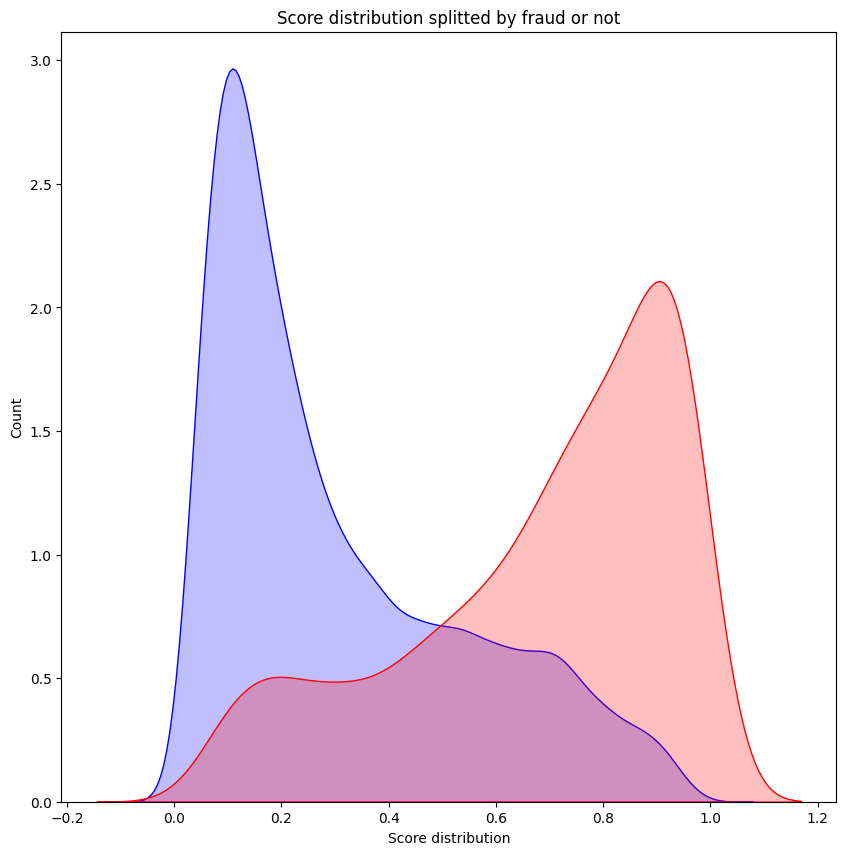

In [155]:
model = random_search.best_estimator_

y_test_pred = model.predict(X_test)
probs_test = model.predict_proba(X_test)

dataframe = df_test.copy()
dataframe['target_col'] = dataframe['fraude'] 
dataframe['prediction_col'] = probs_test[:,1]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.kdeplot(data=dataframe[dataframe['target_col'] == 0], x='prediction_col', ax=ax, color="b", fill=True)
sns.kdeplot(data=dataframe[dataframe['target_col'] == 1], x='prediction_col', ax=ax, color="r", fill=True)

plt.title("Score distribution splitted by fraud or not")
plt.xlabel("Score distribution")
plt.ylabel("Count")
plt.show()

In [156]:
df_test['new_prediction_col'] = probs_test[:, 1] * 100
target_col = "fraude"
prediction_col = "new_prediction_col"
amount_col = "valor_compra" 
blocked_col = "blocked"

possible_thresholds = np.arange(1, 100, 1)
all_decisions = []

for threshold in possible_thresholds:
    df_test["blocked"] = (df_test[prediction_col] >= threshold)
    decision = calculate_profit_metrics(df_test, blocked_col, target_col, amount_col)
    all_decisions.append(decision)

threshold_evaluation = pd.concat(all_decisions, axis=1, keys=possible_thresholds).T.rename_axis("threshold").reset_index()

best_threshold_row = threshold_evaluation.loc[threshold_evaluation["profit"].idxmax()]
best_threshold = best_threshold_row["threshold"]
best_profit = best_threshold_row["profit"]

threshold_evaluation

,threshold,fraud_losses,revenues,profit
0,1,0.00,7.582,7.582
1,2,0.00,149.040,149.040
2,3,0.00,723.860,723.860
3,4,65.38,1822.796,1757.416
4,5,65.38,3686.749,3621.369
...,...,...,...,...
94,95,90193.91,116445.441,26251.531
95,96,99689.00,116711.054,17022.054
96,97,104734.63,116814.069,12079.439
97,98,107588.72,116855.229,9266.509


In [157]:
best_decision_atual = threshold_evaluation.loc[threshold_evaluation["profit"].idxmax()].reset_index()
best_decision_atual.columns = ['metrics', '$']
best_decision_atual.set_index('metrics', inplace=True)
best_decision_atual = best_decision_atual.T
best_decision_atual

metrics,threshold,fraud_losses,revenues,profit
$,67.0,29896.12,97932.204,68036.084


In [158]:
## print the profit ratio
profit_ratio = best_decision_atual["profit"] / best_decision_atual["revenues"]
profit_ratio

$    0.694726
dtype: float64

For the trained model, the threshold that maximizes profit is 64. With this model, we achieve a profit of 71 thousand

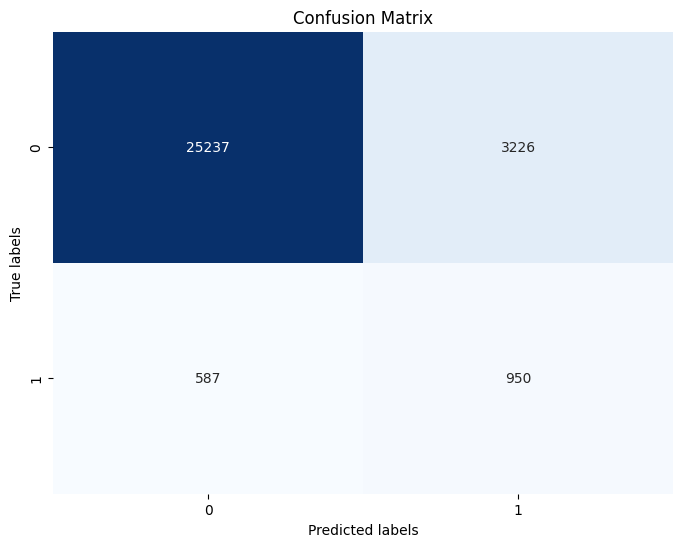

In [159]:
df_test['predicted'] = df_test[prediction_col] >= best_threshold
cm = confusion_matrix(df_test[target_col], df_test['predicted'])
plot_confusion_matrix(cm)

In [160]:
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]


fraud_rate = round(FN / (FN + TN), 2)
approval_rate = round((FN + TN) / (TN + FP + FN + TP), 2)

print(f"Taxa de fraude = {fraud_rate}")
print(f"Taxa de aprovação = {approval_rate}")

Taxa de fraude = 0.02
Taxa de aprovação = 0.86


The fraud rate remains at 0.02 with the trained model, and we have increased the approval rate to 87%

ROC AUC:  0.85


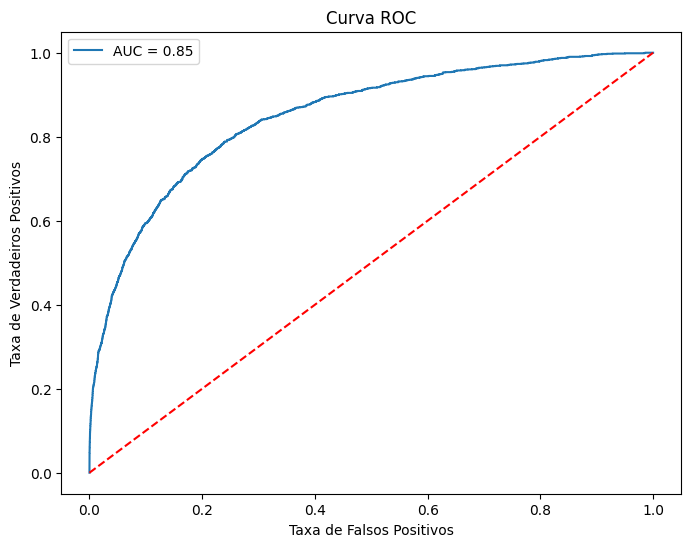

In [161]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(df_test['fraude'], df_test['new_prediction_col'])
auc = auc(fpr, tpr)
print("ROC AUC: ", auc.round(2))

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [162]:
# Converte as probabilidades em classificações binárias com base em um limiar (0.5 é comum)
y_pred_binary = df_test[prediction_col] >= best_threshold

# Calcula as métricas de desempenho
loss = log_loss(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

# Imprime as métricas de desempenho
print(f'Log Loss: {loss:.4f}')
print(f'ROC-AUC: {auc:.4f}')
print(f'Precisão: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

Log Loss: 4.5811
ROC-AUC: 0.8500
Precisão: 0.23
Recall: 0.62
F1-score: 0.33


The AUC for the new model is 0.88. Furthermore, we have lowered the log loss and significantly increased metrics such as precision and f1-score

In [163]:
mlflow.log_metrics({
    "best_profit": best_profit,
    "best_threshold": best_threshold,
    "Log Loss": loss,
    "ROC-AUC": auc,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1,
    "Taxa de fraude": fraud_rate,
    "Taxa de aprovação": approval_rate,
    "Razão de lucro": profit_ratio
})

mlflow.end_run()

# SHAP

In [164]:
#%pip install shap
import shap

shap.initjs()

In [165]:
preprocessing_pipeline = Pipeline(model.steps[:-1])
# Transformando X_test
X_test_transformed = preprocessing_pipeline.transform(X_test)

# Get the actual model from the last step of the pipeline
actual_model = model.steps[-1][1]

# Initialize the SHAP explainer with the extracted model
explainer = shap.Explainer(actual_model)

# Compute SHAP values
shap_values = explainer(X_test_transformed)

In [166]:
np.shape(shap_values.values)

(30000, 26, 2)

Our model has 19 features for each of the 30 thousand instances, and we have two target classes, with 0 representing non-fraud and 1 representing fraud.

We can use the 'waterfall' plot to visualize how the model made decisions. Below, we will plot the first instance of class 0

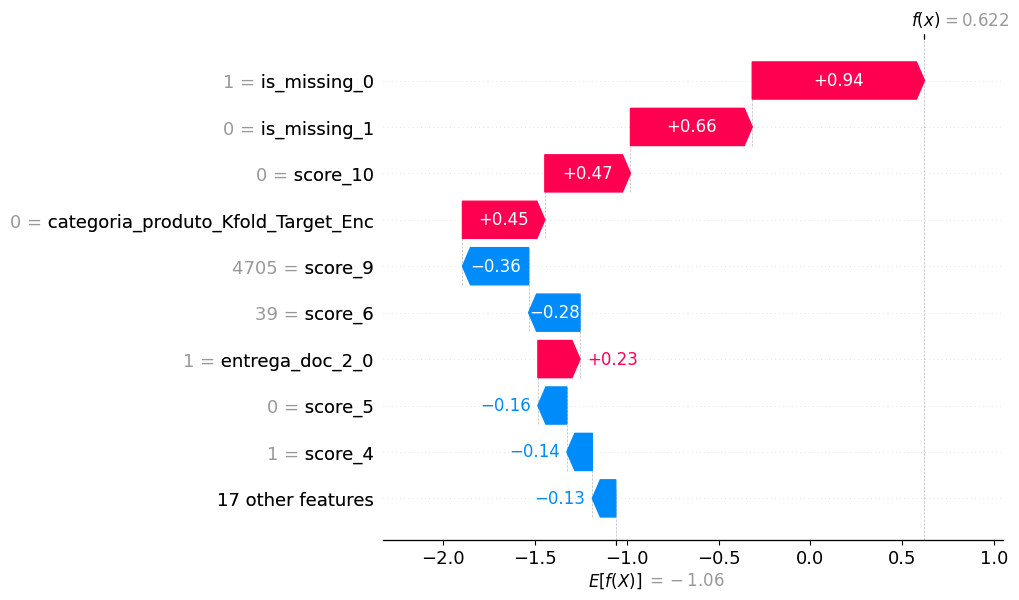

In [167]:
shap.plots.waterfall(shap_values[0, :, 1])

For categorical predictions, we interpret the results in terms of log odds.

In the above graph, E(f(X)) represents the average log odds prediction. The probability given for this instance would be:

ln(P/1-P) = -0.044 -> P = 0.489

Positive SHAP values increase the log odds. For example, the score_9 decreasce the log loss by 0.2

To understand the values in terms of probability, we will use the function below

In [168]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x/e_x.sum(axis = 0)

# converte o softmax para probabilidade
x = [-0.044, 0.044]
softmax(x)

array([0.47801419, 0.52198581])

In [169]:
df_test.iloc[0]['predicted']

False

We can observe that for this first instance, the probability of belonging to the Fraud class is 0.52%. Since our threshold that maximizes profit is higher, we do not classify it as fraud

We can also understand which features are more important for the prediction by using the mean absolute SHAP value

In [170]:
preds = actual_model.predict(X_test_transformed)

new_shap_values = []
for i, pred in enumerate(preds):
    new_shap_values.append(shap_values.values[i][:, pred])

shap_values.values = np.array(new_shap_values)
print(shap_values.shape)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
(30000, 26)


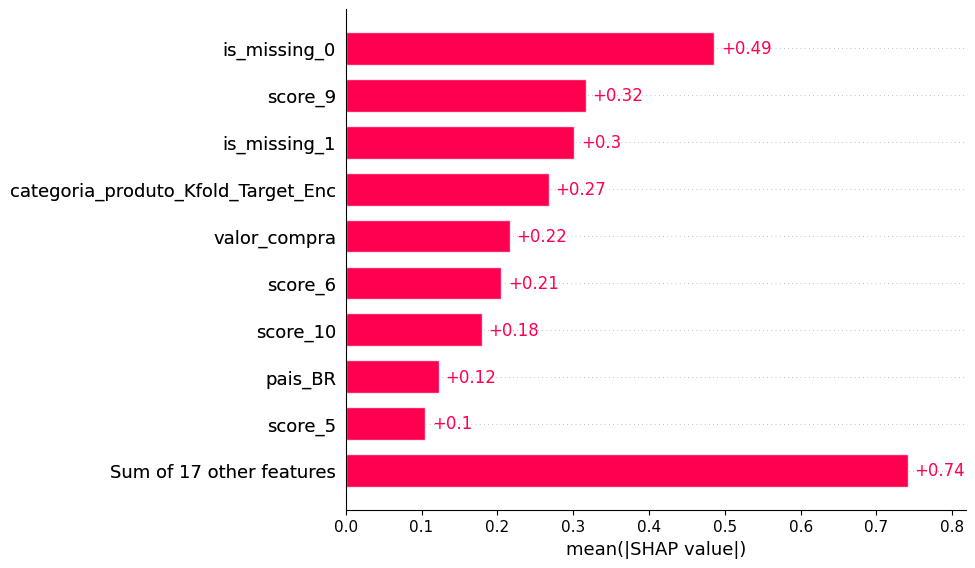

In [171]:
shap.plots.bar(shap_values)

The most relevant features were when `is_missing` is 0, meaning the person submitted `entrega_doc_2`, `score_9`, `categoria_produto`, and the purchase amount

We can also capture the relationship between the features and the model's prediction with the plot below

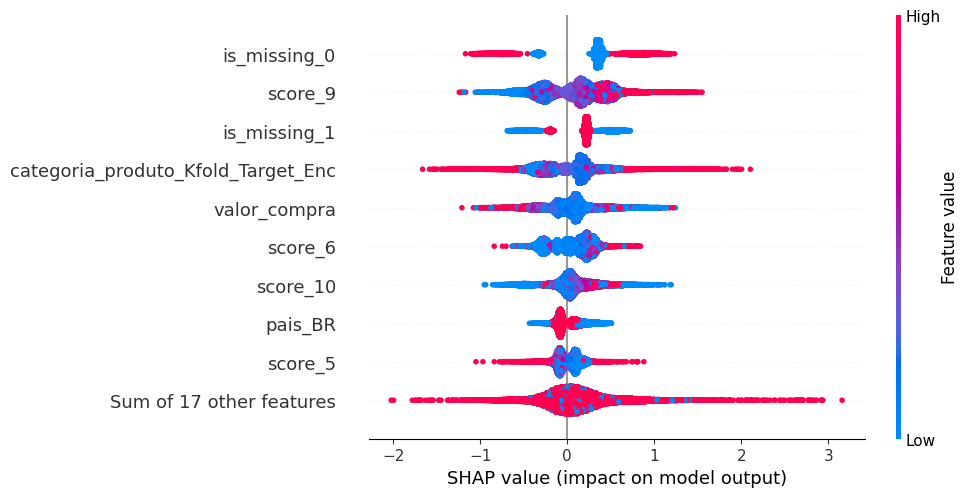

In [172]:
shap.plots.beeswarm(shap_values)

# Analysis of the Difference in Profit between the Current Model and the Trained Model

## Current Model:

| Metrica       | Valor       |
| ------------- | ----------- |
| threshold     | 73.000      |
| fraud_losses  | 25353.320   |
| revenues      | 80329.995   |
| profit        | 54976.675   |

- **Fraud Rate:** 0.02
- **Approval Rate:** 0.74

**Profit-to-Revenues Ratio:** 0.68 (ou 68%)

## Trained Model:

| Metric        | Value       |
| ------------- | ----------- |
| threshold     | 67.000      |
| fraud_losses  | 29896.12    |
| revenues      | 97,932.204  |
| profit        | 68,036.084  |


- **Fraud Rate:** 0.02
- **Approval Rate:** 0.87

**Profit-to-Revenues Ratio:** 0.72 (ou 72%)


# Financial Models Valuation

Given the growth in payments and the application of predictive models to optimize profits, we conducted a simulation to assess the financial impact of transitioning from our Current Model to a Trained Model.

## Data:

- **Total payment volume in a quarter:** 20 M (million)
- **Average transaction value:** $ 43.5

## Calculations:

### Monthly Revenue

First, let's calculate the average monthly revenue for this payment volume:

In [173]:
total_payment_volume = 20  # in millions
average_transaction_value = df['valor_compra'].mean()  # in dollars

print(f"Average value: {average_transaction_value}")

monthly_revenue = (total_payment_volume * average_transaction_value) / 3  # divided by 3 months in a quarter

print(f"Monthly revenue: {monthly_revenue}")


Average value: 43.523134133333336
Monthly revenue: 290.15422755555556


# Current Model Monthly Profit

Based on the current model's profit/revenue ratio:

In [174]:
profit_revenue_ratio_current = 0.68  # or 68%

monthly_profit_current = profit_revenue_ratio_current * monthly_revenue
monthly_profit_current

197.3048747377778

# Monthly Profit for the Trained Model

For the Trained Model:

In [175]:
profit_revenue_ratio_trained = 0.72  # or 72%

monthly_profit_trained = profit_revenue_ratio_trained * monthly_revenue
monthly_profit_trained

208.91104384

# Conclusion

The difference between the profit of the Current Model and the Trained Model represents the potential gain when implementing the new model:

In [176]:
potential_gain = monthly_profit_trained - monthly_profit_current
potential_gain

11.606169102222196

Thus, we observe that the implementation of the Trained Model can bring a significant increase in monthly profit compared to the current model.



# Overall Conclusions

After a thorough analysis of performance metrics and financial valuation for both models, the following points were observed:


1. **Performance Metrics:**:
    - The **Trained Model** showed a significant improvement in various key metrics compared to the **Current Model**:
        - **Log Loss** was reduced from 8.2526 to 3.9888
        - **ROC-AUC** increased from 0.72 to 0.88, suggesting better discrimination capability.
        - **Precisão** increased from 0.13 to 0.27.
        - **Recall** remained constant, ranging from 0.67 to 0.67.
        - **F1-score**, a metric combining precision and recall, improved from 0.22 to 0.38.
        
    This suggests that the Trained Model is more efficient in identifying and preventing fraud without significantly sacrificing legitimate approvals.

2. **Financial Performance**:
    - The **Trained Model** has a higher **Approval Rate** of 0.87 (compared to 0.74 for the Current Model), indicating a higher approval of legitimate transactions.
    - The **Profit/Revenue** Ratio for the Trained Model is 72%, a notable improvement over the 68% of the Current Model.
    - Based on a simulation using a quarterly payment volume of 20 million and an average transaction value of approximately 40 dollars, we estimate that the implementation of the Trained Model could bring an increase of approximately 11.6 million in monthly profit.

3. **Final Considerations**:
    - The transition to the Trained Model not only improves effectiveness in fraud detection and prevention but also has the potential to bring substantial financial gains. The combination of enhanced performance metrics and favorable financial valuation suggests that the adoption of the Trained Model is a solid strategic decision to optimize operations and maximize profits.
